In [123]:
!pip install lmfit
!pip install tikzplotlib

%matplotlib inline
import numpy as np

import pandas as pd 
pd.__version__
from lmfit import models, Parameters, Model
import matplotlib.pyplot as plt
# Use the seborn style
#plt.style.use('seaborn')
import tikzplotlib
import re
from rdflib import Graph, Namespace, URIRef
from rdflib.namespace import RDF
def clean_string(string):
  return re.sub('[^A-Za-z0-9]+','', string )

In [346]:
#fetch sematic data and query for datasets and rois
PMD_CO=Namespace("https://w3id.org/pmd/co/")
OME=Namespace("https://github.com/Mat-O-Lab/OmeroExtractor/raw/main/ome.ttl#")
QUDT = Namespace("http://qudt.org/schema/qudt/")

meta=Graph()
#meta.parse("https://github.com/BAMresearch/DF-TEM-PAW/raw/main/detection_runs-joined.ttl",format='turtle')
meta.parse("./detection_runs-joined.ttl")
#add inverse relation 
#for s,p,o in meta.triples((None,PMD_CO.isRessourceOf,None)):
#    meta.add((o,PMD_CO.ressource,s))
#meta.serialize('detection_runs-joined.ttl')

<Graph identifier=Nb2cbdbe05fdf49daa0e6feb9ec0b7b64 (<class 'rdflib.graph.Graph'>)>

In [305]:
#fetching data from joined graph
q = prepareQuery(
    """
    SELECT ?image ?ome_image ?imagedataset ?ome_dataset ?rois ?ome_rois WHERE 
    {
          ?image ome:dataset ?imagedataset ;
            ome:rois ?rois.
          ?ome_image co:isRessourceOf ?image .
          ?ome_rois co:isRessourceOf ?rois .
          ?ome_dataset co:isRessourceOf ?imagedataset .
    }
    """
    ,
    initNs = { "co": PMD_CO, "ome": OME}
)
qres = meta.query(q)
df = pd.DataFrame(qres, columns =["image", "ome_image", "image_ds", "ome_image_ds", "rois", "ome_rois"])
data=df.groupby("ome_image_ds", group_keys=True).apply(lambda x: x).to_dict('index')
data_dict={ dataset: list() for (dataset, index) in data.keys()}
for (dataset, index),value in data.items(): data_dict[dataset].append(value)

In [388]:
#fetch physical size of images
q = prepareQuery(
    """
    SELECT ?image ?sizex_value ?sizex_unit ?sizey_value ?sizey_unit WHERE 
    {
        ?metadata ome:physicalSizeX ?sizex ;
            ome:physicalSizeY ?sizey.
        ?sizex qudt:value ?sizex_value;
            qudt:unit ?sizex_unit.
        ?sizey qudt:value ?sizey_value;
            qudt:unit ?sizey_unit.
        ?image ome:relates_to ?metadata.
    }
    """
    ,
    initNs = { "qudt": QUDT, "ome": OME}
)
#df = pd.DataFrame(qres, columns =["image", "ome_image", "image_ds", "ome_image_ds", "rois", "ome_rois"])

pysicalsizes=dict()
for dataset, content in data_dict.items():
    images_graph=Graph()
    for record in content:
        images_graph.parse(record['ome_image'],format='json-ld')
    qres = images_graph.query(q)
    df=pd.DataFrame(qres,columns =["image","sizex", "xunit", "sizey", "yunit"])
    df['id']=df['image'].str.rsplit(pat='/', n=1).str[1]
    df.set_index('id',inplace=True)
    pysicalsizes[dataset]=df

    

In [395]:
# reshape countour data and calculate the polygon properties centroid, area
results=dict()
for dataset, content in data_dict.items():
    contour_list=list()
    for record in content:
        shape_graph=Graph()
        shape_graph.parse(record['ome_rois'],format='json-ld')
        polygons_meta=shape_graph.subjects(RDF.type,OME.Polygon)
        image_id=record['ome_rois'].rsplit('/',1)[-1]
        #reshape data
        contour_data=[shape_graph.value(polygon,OME.points).split(' ') for polygon in polygons_meta]
        contour_data=[[point.split(',')for point in contour] for contour in contour_data]
        #to pysical coords
        scale=[float(pysicalsizes[dataset].loc[image_id]['sizex']),float(pysicalsizes[dataset].loc[image_id]['sizey'])]
        contour_data=[np.array(contour).astype('float64')*scale for contour in contour_data]
        contour_list+=contour_data
    #print(np.array(contour_data[0]))
    #calc polygon charakteristics
    polygon_props=list()
    polygons=[Polygon(contour) for contour in contour_list]
    for polygon in polygons:
        # calculate the distance from the centroid to each vertex
        centroid=Point(polygon.centroid)
        distances = [centroid.distance(Point(vertex)) for vertex in polygon.exterior.coords]
        # calculate the mean radius of the polygon, as mean of distance from centrois to exterior points
        mean_radius = sum(distances) / len(distances)
        polygon_props.append({'area': polygon.area, 'centroid': polygon.centroid, 'mean_radius': mean_radius })
    df=pd.DataFrame(polygon_props)
    results[dataset]=df


C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in divide
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in log
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: invalid value encountered in multiply
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))


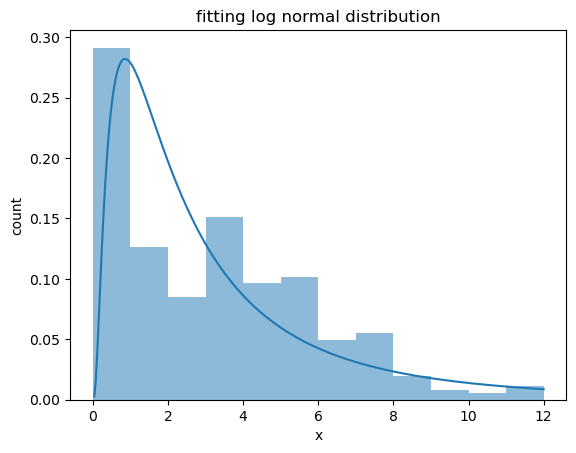

C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in divide
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in log
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: invalid value encountered in multiply
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))


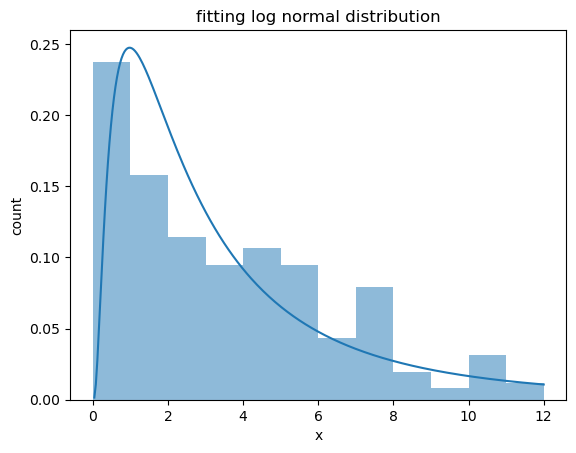

C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in divide
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in log
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: invalid value encountered in multiply
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))


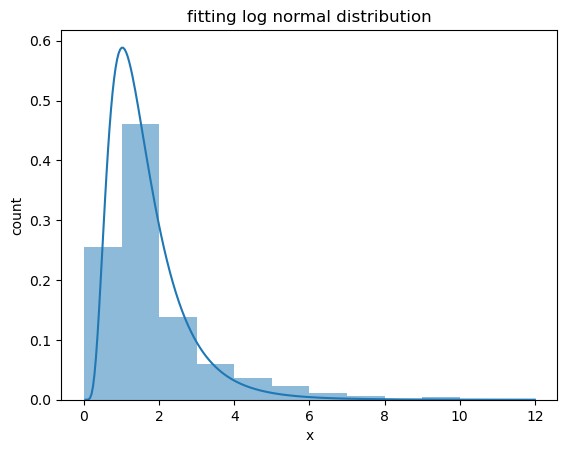

C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in divide
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in log
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: invalid value encountered in multiply
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))


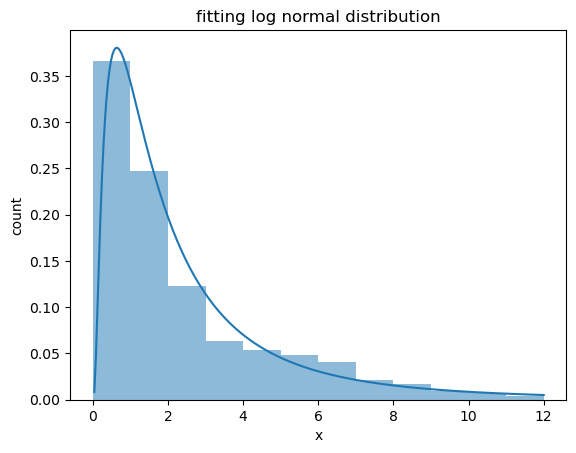

C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in divide
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in log
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: invalid value encountered in multiply
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))


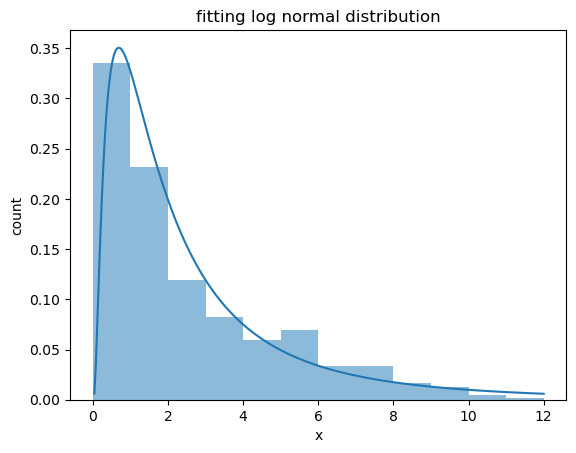

C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in divide
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in log
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: invalid value encountered in multiply
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))


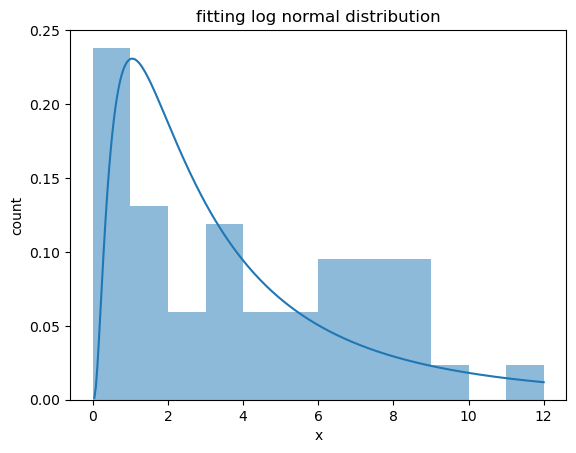

C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in divide
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in log
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: invalid value encountered in multiply
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))


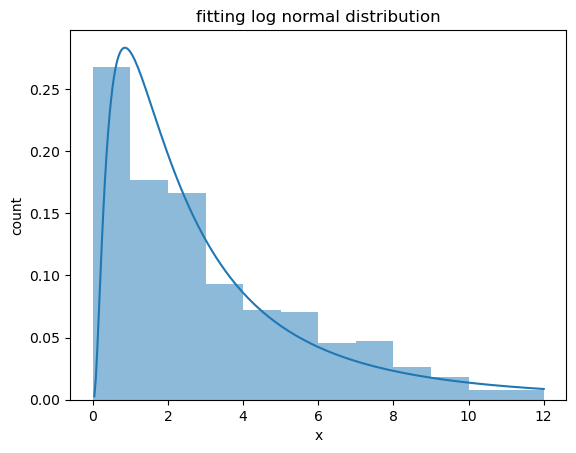

C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in divide
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in log
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: invalid value encountered in multiply
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))


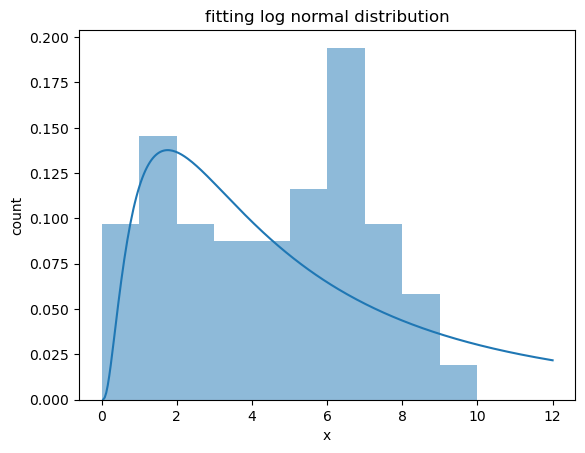

C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in divide
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in log
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: invalid value encountered in multiply
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))


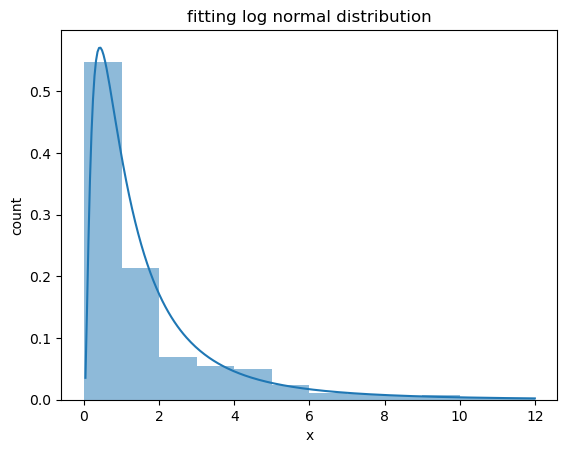

C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in divide
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in log
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: invalid value encountered in multiply
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))


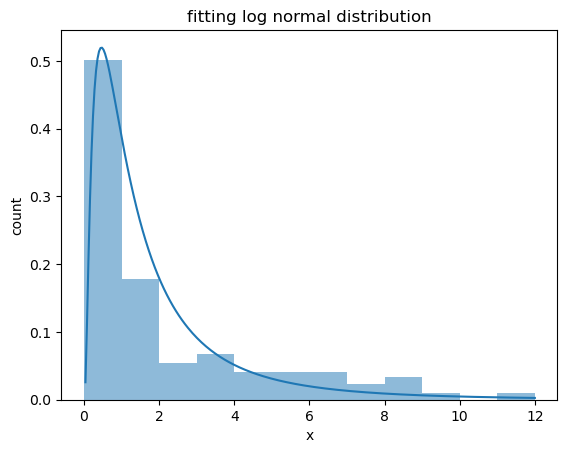

C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in divide
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: divide by zero encountered in log
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_13368\3407567773.py:18: RuntimeWarning: invalid value encountered in multiply
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))


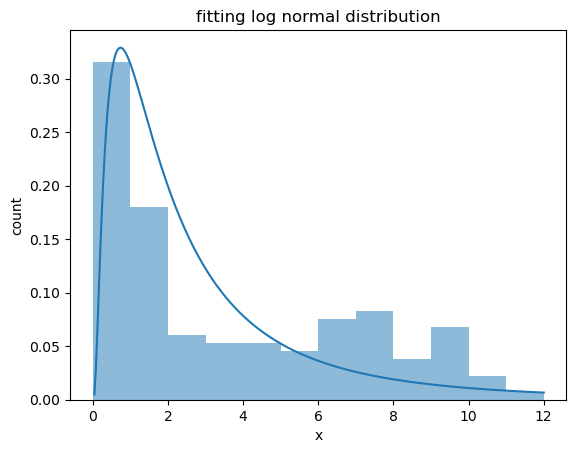

In [405]:
# create histogram and fit distrbution to found polygon areas
for dataset, dataframe in results.items():
    #histogram=get_histogram(dataframe['mean_radius'],plot_result=True)
    histogram=get_histogram(dataframe['mean_radius'])
    fit_log_distribution(histogram['center'],histogram['norm'],plot_result=True)
    #break
    

In [404]:
def get_histogram(y,min_x=0,max_x=12.0,bin_width=1.0,x_label='x',plot_result=False) -> pd.DataFrame:
    num_bins=int((max_x-min_x)/bin_width)
    y_label="normalized count"
    count, bin_edges= np.histogram(y,bins=num_bins, range=(min_x,max_x))
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    hist=pd.DataFrame({'center': bin_centers, 'count': count})
    hist['norm']=hist['count']/hist['count'].sum()
    if plot_result:
        plt.figure()
        plt.bar(hist['center'], hist['count'], width=bin_width, alpha=0.5,align='center')
        plt.xlabel(x_label)
        plt.ylabel('count')
        plt.show()
    return hist

#log distrubition fumction
def rock(x, rm, sigma):
    return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))

def fit_log_distribution(x, y, start=0,end=12, bin_width=1.0, x_label='x', plot_result=False) -> dict:
    results=dict()
    x_sim=np.linspace(start,end,300)
    #https://lmfit.github.io/lmfit-py/builtin_models.html#lognormalmodel
    title="fitting log normal distribution"
    fit=pd.DataFrame(columns=('x','y','dely'))
    model = Model(rock)
    #params = model.make_params(sigma=3.0, rm=1.0)
    params = Parameters()
    #params.add('amp', value=1.0, min=1E-10, max=1E6, vary=False)
    params.add('sigma', value=0.5, min=0.1, max=1.0,vary=True)
    params.add('rm', value=3.0, min=0.5,max=100, vary=True)
    result = model.fit(y, params, x=x)
    #print(result.fit_report())
    
    fit['x']=x_sim
    fit['y']=model.eval(x=x_sim, params=result.params)
    fit['dely'] = result.eval_uncertainty(x=x_sim)
    results['chi squared']=result.chisqr
    # results.at[key,'R squared']=result.rsquared
    # results.at[key,'amplitude']=result.params['amp'].value
    # results.at[key,'amplitude stderr']=result.params['amp'].stderr
    results['rm']=result.params['rm'].value
    results['rm stderr']=result.params['rm'].stderr
    results['sigma']=result.params['sigma'].value
    results['sigma stderr']=result.params['sigma'].stderr
    results['ra']=result.params['rm'].value*np.exp((result.params['sigma'].value**2)/2)
    results['ra stderr']=result.params['rm'].stderr*np.exp((result.params['sigma'].value**2)/2)
    results['fit']=fit
    if plot_result:
        plt.figure()
        plt.title(title)
        plt.bar(x, y, width=bin_width, alpha=0.5,align='center')
        plt.plot(fit['x'], fit['y'], label='fit')
        plt.xlabel(x_label)
        plt.ylabel('count')
        plt.show()
    return results

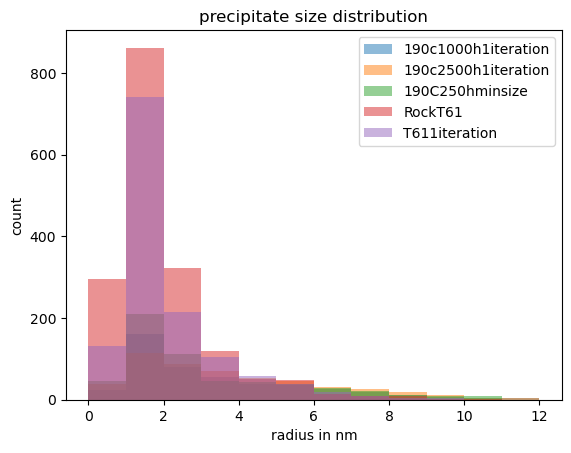

In [13]:
#plot all histograms
title='precipitate size distribution'
plt.figure()
for key, value in datatofit.items():
  plt.bar(value['center'], value['count'], width=bin_width, alpha=0.5,align='center',label=key)
  # plt.plot(value[col_label_x],value[col_label_y],label=key)
  plt.title(title)
  plt.xlabel(plot_x_label)
  plt.ylabel('count')
  plt.legend()
plt.show()
  #tikzplotlib.save("{}.tex".format(title.replace(' ','_')))

[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 12
    # variables        = 2
    chi-square         = 0.00908716
    reduced chi-square = 9.0872e-04
    Akaike info crit   = -82.2295946
    Bayesian info crit = -81.2597813
[[Variables]]
    sigma:  0.68788497 +/- 0.04542636 (6.60%) (init = 0.5)
    rm:     2.39575023 +/- 0.16174822 (6.75%) (init = 3)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = 0.287


C:\Users\hanke\AppData\Local\Temp\ipykernel_16024\3859978165.py:9: RuntimeWarning: divide by zero encountered in divide
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_16024\3859978165.py:9: RuntimeWarning: divide by zero encountered in log
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_16024\3859978165.py:9: RuntimeWarning: invalid value encountered in multiply
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))


AttributeError: 'ModelResult' object has no attribute 'rsquared'

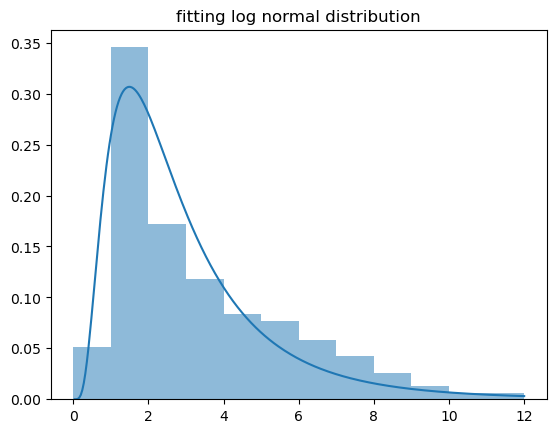

In [16]:
#results=pd.DataFrame(columns=('amplitude','amplitude stderr','center','center stderr','sigma','sigma stderr','fwhm','fwhm stderr','height','height stderr','chi squared'))
results=pd.DataFrame(columns=('rm','rm stderr','sigma','sigma stderr','ra','ra stderr','chi squared'))
start=0
end=max_x
x_sim=np.linspace(start,end,300)
def rock(x, rm, sigma):
    #return amp/(x*sigma*np.sqrt(2*np.pi))*np.exp((np.log(x/rm))**2/(2*sigma))
    #return amp/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x/rm))**2/(2*sigma))
    return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))

fits=dict()
#https://lmfit.github.io/lmfit-py/builtin_models.html#lognormalmodel
title="fitting log normal distribution"
for key, value in datatofit.items():
  x=value['center']
  y=value['norm']
  fit=pd.DataFrame(columns=('x','y','dely'))
  model = Model(rock)
  #params = model.make_params(sigma=3.0, rm=1.0)
  params = Parameters()
  #params.add('amp', value=1.0, min=1E-10, max=1E6, vary=False)
  params.add('sigma', value=0.5, min=0.1, max=1.0,vary=True)
  params.add('rm', value=3.0, min=0.5,max=100, vary=True)

  result = model.fit(y, params, x=x)
  print(result.fit_report())
  plt.title(title)
  plt.bar(x, y, width=bin_width, alpha=0.5,align='center',label=key)
  
  #plt.plot(x, result.best_fit, label=key+'-fit')
  fit['x']=x_sim
  fit['y']=model.eval(x=x_sim, params=result.params)
  fit['dely'] = result.eval_uncertainty(x=x_sim)
  plt.plot(fit['x'], fit['y'], label=key+'-eval')
  results.at[key,'chi squared']=result.chisqr
  # results.at[key,'R squared']=result.rsquared
  # results.at[key,'amplitude']=result.params['amp'].value
  # results.at[key,'amplitude stderr']=result.params['amp'].stderr
  results.at[key,'rm']=result.params['rm'].value
  results.at[key,'rm stderr']=result.params['rm'].stderr
  results.at[key,'sigma']=result.params['sigma'].value
  results.at[key,'sigma stderr']=result.params['sigma'].stderr
  results.at[key,'ra']=result.params['rm'].value*np.exp((result.params['sigma'].value**2)/2)
  results.at[key,'ra stderr']=result.params['rm'].stderr*np.exp((result.params['sigma'].value**2)/2)
  fits[key]=fit
  
plt.legend()
plt.show()
#tikzplotlib.save("{}.tex".format(title.replace(' ','_')))
results.to_csv('log_fit.csv')

In [15]:
results

,rm,rm stderr,sigma,sigma stderr,ra,ra stderr,chi squared
190c1000h1iteration,2.39575,0.161748,0.687885,0.045426,3.035236,0.204923,0.009087
190c2500h1iteration,3.192353,0.117005,0.821823,0.026527,4.474768,0.164008,0.001365
190C250hminsize,2.13672,0.122057,0.660241,0.03601,2.657088,0.151782,0.007674
RockT61,1.526577,0.019523,0.537514,0.006942,1.763832,0.022557,0.00063
T611iteration,1.51535,0.04371,0.473941,0.013015,1.695464,0.048905,0.003615


190c1000h1iteration Index(['center', 'count', 'norm'], dtype='object')
190c2500h1iteration Index(['center', 'count', 'norm'], dtype='object')
T611iteration Index(['center', 'count', 'norm'], dtype='object')
190C250hminsize Index(['center', 'count', 'norm'], dtype='object')


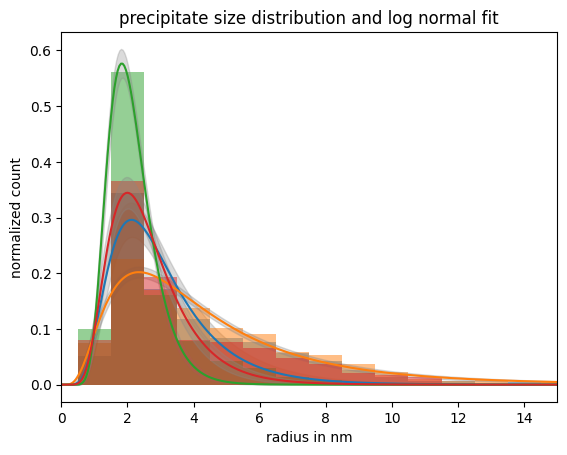

In [159]:
# plot all histograms and fitted lognormal distributions
model =models.LognormalModel()
title='precipitate size distribution and log normal fit'
for key, value in datatofit.items():
  print(key,value.columns) #width=bin_width, alpha=0.5, 
  plt.bar(value['center'], value['norm'], width=bin_width, alpha=0.5,align='center',label=key)
  # plt.plot(value[col_label_x],value[col_label_y],label=key)
  plt.title(title)
  plt.xlabel(plot_x_label)
  plt.ylabel(plot_y_label)
  plt.plot(fits[key]['x'], fits[key]['y'],label=key+'-fit')
  plt.fill_between(fits[key]['x'], fits[key]['y']-fits[key]['dely'],
                fits[key]['y']+fits[key]['dely'], color='#888888',alpha=0.3)
  plt.xlim([0.0, max_x])
  #plt.legend()
  tikzplotlib.save("{}.tex".format(title.replace(' ','_')))


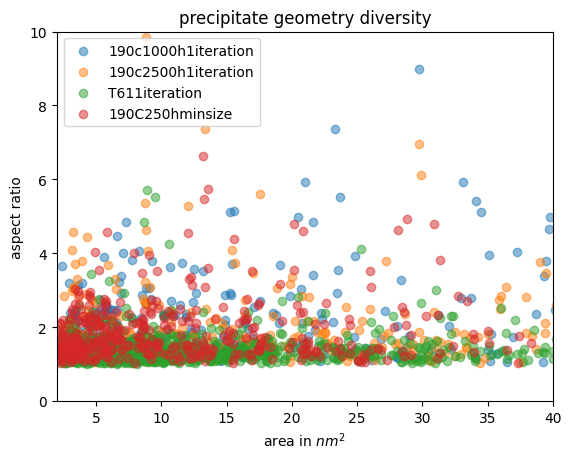

In [160]:
#visualize geometry diversity
title='precipitate geometry diversity'
for key, value in data.items():
  plt.scatter(x=data[key]['area_in_nm2'],y=data[key]['aspect_ratio'], alpha=0.5, label=key)
  plt.title(title)
  plt.xlabel(r'area in $nm^2$')
  plt.ylabel('aspect ratio')
  plt.xlim([2,40])
  plt.ylim([0,10])
plt.legend()
plt.show()  
#tikzplotlib.save("{}.tex".format(title.replace(' ','_')))
